# MC REINFORCE

In [1]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('Acrobot-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print("State shape:", state_shape)
print("Number of Actions: ",no_of_actions)
print("Sampled Action",env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print("Current_State: ",state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print("Sampled Action2: ", action)
print("----")

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print("Next_State: ",next_state)
print("Reward: ",reward)
print("Done: ", done)
print("Info: ", info)
print("----")


State shape: 6
Number of Actions:  3
Sampled Action 1
----
Current_State:  [ 0.99962485  0.02738891  0.9989402  -0.04602639 -0.09180529 -0.09669447]
----
Sampled Action2:  2
----
Next_State:  [ 0.99996984 -0.0077642   0.9997182  -0.02373883 -0.25169677  0.31000718]
Reward:  -1.0
Done:  False
Info:  {}
----


# MC REINFORCE W/O BASELINE

In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import torch
import numpy as np
from collections import deque, namedtuple

from scipy.special import softmax
from torch.distributions import Categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
'''BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)'''

class Policy(nn.Module):

    def __init__(self, state_size, action_size, seed=0, num_policy_layers =1,num_policy_layer_units= 64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Policy, self).__init__()
        self.seed = torch.manual_seed(seed)
        activation = nn.LeakyReLU
        self.fc_start = nn.Sequential(*[nn.Linear(state_size, num_policy_layer_units),activation()])
        self.fc_hidden = nn.Sequential(*[nn.Sequential(*[nn.Linear(num_policy_layer_units,num_policy_layer_units),activation()]) for _ in range(num_policy_layers-1)])
        self.fc_end = nn.Linear(num_policy_layer_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        xs = self.fc_start(state)
        x_hidden = self.fc_hidden(xs)
        x_out = self.fc_end(x_hidden)
        return F.softmax(x_out, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)


In [4]:
def reinforce(policy, optimizer, n_episodes=1000, max_t=1000, gamma=0.99, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break

        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Convert rewards to torch tensor
        rewards = torch.FloatTensor(rewards)

        # Calculate discounted returns
        discounts = torch.FloatTensor([gamma ** i for i in range(len(rewards))])
        returns = torch.FloatTensor([sum(rewards[i:] * discounts[:len(rewards)-i]) for i in range(len(rewards))])

        # Calculate policy loss
        policy_loss = []
        for log_prob, ret in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * ret)
        policy_loss = torch.stack(policy_loss).sum()

        # Backpropagation and optimization step
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))

    return scores

In [5]:
import pandas as pd

In [8]:
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n
num_exp = 5
max_episodes = 1000
total_rewards = np.zeros([num_exp,max_episodes])
for i in range(num_exp):
    state_shape = env.observation_space.shape[0]
    action_shape = env.action_space.n
    policy = Policy(state_size=state_shape, action_size=action_shape, seed=i, num_policy_layers =2,num_policy_layer_units= 256).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=1e-3)
    scores = reinforce(policy, optimizer, n_episodes=max_episodes)
    total_rewards[i] = scores
Regret = np.mean(np.sum(500-total_rewards,axis=1),axis=0)

Episode 0	Average Score: -500.00
Episode 100	Average Score: -120.54
Episode 200	Average Score: -94.97
Episode 300	Average Score: -89.50
Episode 400	Average Score: -87.16
Episode 500	Average Score: -100.91
Episode 600	Average Score: -97.32
Episode 700	Average Score: -89.37
Episode 800	Average Score: -85.87
Episode 900	Average Score: -87.15
Episode 0	Average Score: -500.00
Episode 100	Average Score: -176.56
Episode 200	Average Score: -128.54
Episode 300	Average Score: -111.97
Episode 400	Average Score: -101.34
Episode 500	Average Score: -87.94
Episode 600	Average Score: -97.16
Episode 700	Average Score: -123.16
Episode 800	Average Score: -85.67
Episode 900	Average Score: -91.15
Episode 0	Average Score: -500.00
Episode 100	Average Score: -165.97
Episode 200	Average Score: -126.56
Episode 300	Average Score: -116.27
Episode 400	Average Score: -133.46
Episode 500	Average Score: -152.92
Episode 600	Average Score: -121.87
Episode 700	Average Score: -117.99
Episode 800	Average Score: -99.26
Epi

In [9]:
Regret_type1 = np.mean(np.sum(500-total_rewards,axis=1),axis=0)
print("\nRegret =", Regret_type1)



Regret = 700465.4


In [ ]:
rewards_mean_type1 = np.mean(total_rewards,axis=0)
reward_std_type1 = np.std(total_rewards, axis=0)

In [33]:
# Assuming your DataFrame is named 'df'
rewards_mean_type1 = np.mean(total_rewards[[0,1, 2]], axis=0)
reward_std_type1 = np.std(total_rewards[[0,1, 2]], axis=0)

In [34]:
data = np.vstack([rewards_mean_type1,reward_std_type1]).T
dff= pd.DataFrame(np.array(data),columns = ["Mean","Std"])
dff.to_csv("MC_REINFORCE_WOB_10AM_Acrobot_3avg.csv", index = False)

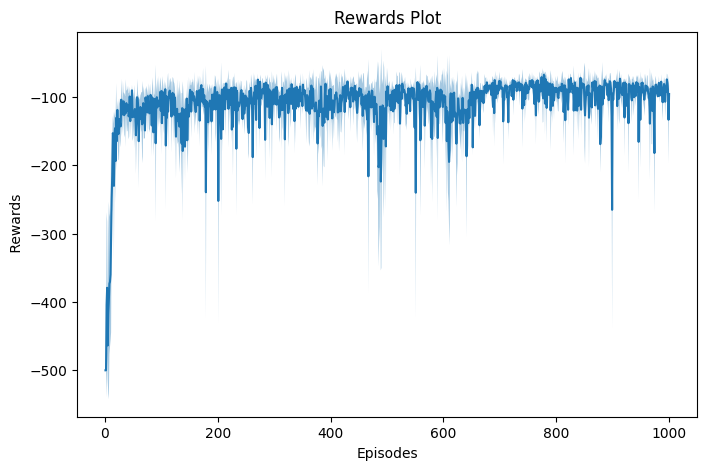

In [39]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1,len(rewards_mean_type1)+1),rewards_mean_type1)
plt.fill_between(np.arange(1,len(rewards_mean_type1)+1),rewards_mean_type1 - reward_std_type1,rewards_mean_type1 + reward_std_type1, alpha=0.4)
plt.xlabel("Episodes")
plt.ylabel(" Rewards")
plt.title("Rewards Plot")
plt.show()

# version 2


In [28]:
# Assuming your DataFrame is named 'df'
rewards_mean_type1 = np.mean(total_rewards[[0,1, 2,4]], axis=0)
reward_std_type1 = np.std(total_rewards[[0,1, 2,4]], axis=0)

In [21]:
data = np.vstack([rewards_mean_type1,reward_std_type1]).T
dff= pd.DataFrame(np.array(data),columns = ["Mean","Std"])
dff.to_csv("MC_REINFORCE_WOB_10AM_Acrobot_4avg.csv", index = False)

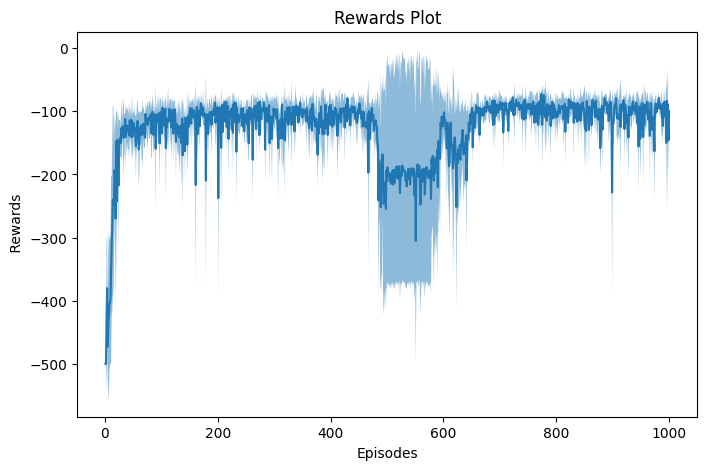

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1,len(rewards_mean_type1)+1),rewards_mean_type1)
plt.fill_between(np.arange(1,len(rewards_mean_type1)+1),rewards_mean_type1 - reward_std_type1,rewards_mean_type1 + reward_std_type1, alpha=0.5)
plt.xlabel("Episodes")
plt.ylabel(" Rewards")
plt.title("Rewards Plot")
plt.show()

# version 3


In [23]:
# Assuming your DataFrame is named 'df'
rewards_mean_type1 = np.mean(total_rewards[[0,1, 2,3,4]], axis=0)
reward_std_type1 = np.std(total_rewards[[0,1, 2,3,4]], axis=0)

In [24]:
data = np.vstack([rewards_mean_type1,reward_std_type1]).T
dff= pd.DataFrame(np.array(data),columns = ["Mean","Std"])
dff.to_csv("MC_REINFORCE_WOB_10AM_Acrobot_5avg.csv", index = False)

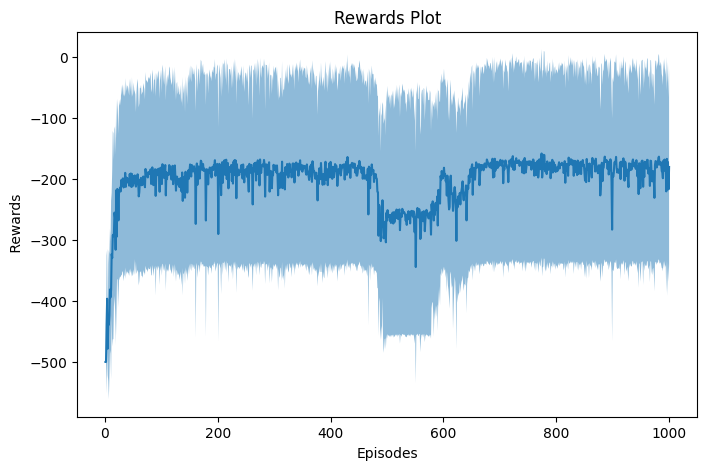

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1,len(rewards_mean_type1)+1),rewards_mean_type1)
plt.fill_between(np.arange(1,len(rewards_mean_type1)+1),rewards_mean_type1 - reward_std_type1,rewards_mean_type1 + reward_std_type1, alpha=0.5)
plt.xlabel("Episodes")
plt.ylabel(" Rewards")
plt.title("Rewards Plot")
plt.show()

# Final Draft

In [ ]:
#!pip install wandb

In [ ]:
import wandb
wandb.login(key = "8545e71f98dc96fbac53295facb12404fc77016d")

wandb: Currently logged in as: nayinisriharsh-iitm. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\nayin\.netrc


True

In [ ]:
def train_and_tune(config=None):
  # Initialize a new wandb run
  with wandb.init(config=config):
    # If called by wandb.agent, as below,
    # this config will be set by Sweep Controller
    config = wandb.config
    wandb.run.name='plr'+str(config.policy_lr)+'-nlr'+str(config.num_policy_layers)+'-uts'+str(config.num_policy_layer_units)
    state_shape = env.observation_space.shape[0]
    action_shape = env.action_space.n
    num_exp = 1
    max_episodes = 1000
    total_rewards = np.zeros([num_exp,max_episodes])
    for i in range(num_exp):
        state_shape = env.observation_space.shape[0]
        action_shape = env.action_space.n
        policy = Policy(state_size=state_shape, action_size=action_shape, seed=i, num_policy_layers =config.num_policy_layers,num_policy_layer_units= config.num_policy_layer_units).to(device)
        optimizer = optim.Adam(policy.parameters(), lr=config.policy_lr)
        scores = reinforce(policy, optimizer, n_episodes=max_episodes)
        total_rewards[i] = scores
    Regret = np.mean(np.sum(0-total_rewards,axis=1),axis=0)
    #wandb.log({"train_mean_reward":rewards,"train_mean_steps":steps,"test_mean_reward":r,"train_mean_steps":s})
    #data = [[x, y] for (x, y) in zip(np.arange(config.episodes), rewards)]
    #table1 = wandb.Table(data=data, columns=["x", "y"])
    #data = [[x, y] for (x, y) in zip(np.arange(config.episodes), steps)]
    #table2 = wandb.Table(data=data, columns=["x", "y"])
    wandb.log(
        {
            "avg_regret":Regret#,'avg_test_steps':s #,"train_reward": wandb.plot.line(table1, "x", "y", title="Reward vs Episode"),"train_steps": wandb.plot.line(table2, "x", "y", title="Steps vs Episode"),
        }
    )

In [ ]:
sweep_config={'method':'bayes',
              'metric' : {
                  'name':'avg_regret',
                  'goal':'minimize'},
              'parameters':{
                  'policy_lr':{'values':[1e-2, 1e-3, 1e-4]},
                  'num_policy_layers':{'values':[1,2,3]},
                  'num_policy_layer_units':{'values':[64,128,256]},
                  }}
import pprint
pprint.pprint(sweep_config)
sweep_id=wandb.sweep(sweep_config,project="CS6700_PROGRAMMING_ASSIGNMENT_2")

{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'avg_regret'},
 'parameters': {'num_policy_layer_units': {'values': [64, 128, 256]},
                'num_policy_layers': {'values': [1, 2, 3]},
                'policy_lr': {'values': [0.01, 0.001, 0.0001]}}}
Create sweep with ID: rvn1z633
Sweep URL: https://wandb.ai/nayinisriharsh-iitm/CS6700_PROGRAMMING_ASSIGNMENT_2/sweeps/rvn1z633


{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'avg_regret'},
 'parameters': {'act_algorithm': {'values': ['softmax', 'epsilon']},
                'batch_size': {'values': [32, 64, 128]},
                'buffer_size': {'values': [100, 1000, 10000, 100000]},
                'epsilon_tau_decay': {'values': [0.995, 0.95, 0.9, 0.85]},
                'epsilon_tau_start': {'values': [1, 0.5]},
                'lr': {'values': [0.01, 0.001, 0.0001]},
                'num_common_layer_units': {'values': [128, 256, 512]},
                'num_common_layers': {'values': [1, 2, 3]},
                'type': {'values': [1]},
                'update_every': {'values': [10, 20, 30]}}}
Create sweep with ID: 29klzxlf
Sweep URL: https://wandb.ai/nayinisriharsh-iitm/CS6700_PROGRAMMING_ASSIGNMENT_2/sweeps/rvn1z633

In [ ]:
wandb.agent(sweep_id, train_and_tune,count=40)

wandb: Agent Starting Run: 09o68xbr with config:
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.01


Episode 0	Average Score: -500.00
Episode 100	Average Score: -500.00
Episode 200	Average Score: -500.00
Episode 300	Average Score: -500.00
Episode 400	Average Score: -500.00
Episode 500	Average Score: -500.00
Episode 600	Average Score: -500.00
Episode 700	Average Score: -500.00
Episode 800	Average Score: -500.00
Episode 900	Average Score: -500.00


avg_regret,▁
avg_regret,500000.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fkcjh63f with config:
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 3
wandb: 	policy_lr: 0.001


Episode 0	Average Score: -500.00
Episode 100	Average Score: -500.00
Episode 200	Average Score: -500.00
Episode 300	Average Score: -500.00
Episode 400	Average Score: -500.00
Episode 500	Average Score: -500.00
Episode 600	Average Score: -500.00
Episode 700	Average Score: -500.00
Episode 800	Average Score: -500.00
Episode 900	Average Score: -500.00


avg_regret,▁
avg_regret,500000.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c9o913xs with config:
wandb: 	num_policy_layer_units: 64
wandb: 	num_policy_layers: 3
wandb: 	policy_lr: 0.001


Episode 0	Average Score: -500.00
Episode 100	Average Score: -479.18
Episode 200	Average Score: -494.71
Episode 300	Average Score: -464.62
Episode 400	Average Score: -253.27
Episode 500	Average Score: -135.79
Episode 600	Average Score: -105.73
Episode 700	Average Score: -93.27
Episode 800	Average Score: -121.79
Episode 900	Average Score: -111.27


avg_regret,▁
avg_regret,238355.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2c4ejfs9 with config:
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 3
wandb: 	policy_lr: 0.001


Episode 0	Average Score: -500.00
Episode 100	Average Score: -479.09
Episode 200	Average Score: -311.91
Episode 300	Average Score: -201.91
Episode 400	Average Score: -150.42
Episode 500	Average Score: -110.99
Episode 600	Average Score: -112.31
Episode 700	Average Score: -114.79
Episode 800	Average Score: -105.68
Episode 900	Average Score: -97.66


avg_regret,▁
avg_regret,177916.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dssvm36i with config:
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.001


Episode 0	Average Score: -500.00
Episode 100	Average Score: -184.19
Episode 200	Average Score: -177.82
Episode 300	Average Score: -133.01
Episode 400	Average Score: -100.75
Episode 500	Average Score: -107.39
Episode 600	Average Score: -116.52
Episode 700	Average Score: -139.05
Episode 800	Average Score: -93.97
Episode 900	Average Score: -107.66


avg_regret,▁
avg_regret,125168.0


wandb: Agent Starting Run: 9mnchslb with config:
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 3
wandb: 	policy_lr: 0.001


Episode 0	Average Score: -500.00
Episode 100	Average Score: -499.91
Episode 200	Average Score: -495.84
Episode 300	Average Score: -500.00
Episode 400	Average Score: -498.45
Episode 500	Average Score: -233.74
Episode 600	Average Score: -94.54
Episode 700	Average Score: -90.62
Episode 800	Average Score: -85.80
Episode 900	Average Score: -101.20


avg_regret,▁
avg_regret,270553.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v7fr1jb5 with config:
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 3
wandb: 	policy_lr: 0.001


Episode 0	Average Score: -500.00
Episode 100	Average Score: -498.61
Episode 200	Average Score: -255.95
Episode 300	Average Score: -131.34
Episode 400	Average Score: -96.20
Episode 500	Average Score: -102.93
Episode 600	Average Score: -99.65
Episode 700	Average Score: -110.51
Episode 800	Average Score: -86.80
Episode 900	Average Score: -90.91


avg_regret,▁
avg_regret,156131.0


wandb: Agent Starting Run: wzwm73in with config:
wandb: 	num_policy_layer_units: 64
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.01


Episode 0	Average Score: -500.00
Episode 100	Average Score: -499.80
Episode 200	Average Score: -500.00
Episode 300	Average Score: -497.67
Episode 400	Average Score: -500.00
Episode 500	Average Score: -500.00
Episode 600	Average Score: -500.00
Episode 700	Average Score: -500.00
Episode 800	Average Score: -500.00
Episode 900	Average Score: -500.00


avg_regret,▁
avg_regret,499747.0


wandb: Agent Starting Run: r1ufvqww with config:
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 3
wandb: 	policy_lr: 0.001


Episode 0	Average Score: -500.00
Episode 100	Average Score: -306.47
Episode 200	Average Score: -209.31
Episode 300	Average Score: -114.42
Episode 400	Average Score: -95.35
Episode 500	Average Score: -93.36
Episode 600	Average Score: -90.50
Episode 700	Average Score: -86.29
Episode 800	Average Score: -84.91
Episode 900	Average Score: -90.55


avg_regret,▁
avg_regret,126793.0


wandb: Agent Starting Run: 2j6vy07s with config:
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.001


Episode 0	Average Score: -500.00
Episode 100	Average Score: -500.00
Episode 200	Average Score: -492.94
Episode 300	Average Score: -314.29
Episode 400	Average Score: -160.45
Episode 500	Average Score: -140.37
Episode 600	Average Score: -150.91
Episode 700	Average Score: -153.72
Episode 800	Average Score: -159.31
Episode 900	Average Score: -164.39


avg_regret,▁
avg_regret,247580.0


wandb: Agent Starting Run: 6ofpirfk with config:
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 3
wandb: 	policy_lr: 0.001


Episode 0	Average Score: -500.00
Episode 100	Average Score: -500.00
Episode 200	Average Score: -500.00
Episode 300	Average Score: -500.00
Episode 400	Average Score: -500.00
Episode 500	Average Score: -500.00
Episode 600	Average Score: -500.00
Episode 700	Average Score: -500.00
Episode 800	Average Score: -500.00
Episode 900	Average Score: -500.00


avg_regret,▁
avg_regret,500000.0


wandb: Agent Starting Run: kwanqqeq with config:
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.01


Episode 0	Average Score: -500.00
Episode 100	Average Score: -499.80
Episode 200	Average Score: -500.00
Episode 300	Average Score: -500.00
Episode 400	Average Score: -500.00
Episode 500	Average Score: -500.00
Episode 600	Average Score: -500.00
Episode 700	Average Score: -500.00
Episode 800	Average Score: -500.00
Episode 900	Average Score: -500.00


avg_regret,▁
avg_regret,499980.0


wandb: Agent Starting Run: 29teqpjr with config:
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.0001


Episode 0	Average Score: -500.00
Episode 100	Average Score: -500.00
Episode 200	Average Score: -500.00
Episode 300	Average Score: -500.00
Episode 400	Average Score: -500.00
Episode 500	Average Score: -500.00
Episode 600	Average Score: -500.00
Episode 700	Average Score: -500.00
Episode 800	Average Score: -500.00
Episode 900	Average Score: -500.00


avg_regret,▁
avg_regret,499821.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vitrpxxv with config:
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.0001


Episode 0	Average Score: -500.00
Episode 100	Average Score: -500.00
Episode 200	Average Score: -500.00
Episode 300	Average Score: -499.58
Episode 400	Average Score: -498.07
Episode 500	Average Score: -482.55
Episode 600	Average Score: -465.64
Episode 700	Average Score: -441.43
Episode 800	Average Score: -351.53
Episode 900	Average Score: -292.08


avg_regret,▁
avg_regret,428557.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ar7llpxd with config:
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.0001


Episode 0	Average Score: -500.00
Episode 100	Average Score: -498.42
Episode 200	Average Score: -489.59
Episode 300	Average Score: -500.00
Episode 400	Average Score: -499.02
Episode 500	Average Score: -498.12
Episode 600	Average Score: -326.12
Episode 700	Average Score: -167.49
Episode 800	Average Score: -147.91
Episode 900	Average Score: -142.43


avg_regret,▁
avg_regret,340586.0


wandb: Agent Starting Run: yf830qly with config:
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 3
wandb: 	policy_lr: 0.0001


Episode 0	Average Score: -500.00
Episode 100	Average Score: -500.00
Episode 200	Average Score: -500.00
Episode 300	Average Score: -500.00
Episode 400	Average Score: -500.00
Episode 500	Average Score: -500.00
Episode 600	Average Score: -500.00


Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "C:\Users\nayin\anaconda3\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "C:\Users\nayin\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\nayin\anaconda3\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\nayin\anaconda3\lib\site-packages\wandb\sdk\wandb_run.py", line 286, in check_stop_status
    self._loop_check_status(
  File "C:\Users\nayin\anaconda3\lib\site-packages\wandb\sdk\wandb_run.py", line 224, in _loop_check_status
    local_handle = request()
  File "C:\Users\nayin\anaconda3\lib\site-packages\wandb\sdk\interface\interface.py", line 787, in deliver_stop_status
    return self._deliver_stop_status(status)
  File "C:\Users\nayin\anaconda3\lib\site-packages\wandb\sdk\interface\interface_shared.py", line 484, in _deliver_stop_status
    ret